### **Using Pipelines to preprocess and create a model**

### Import the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

plt.style.use("seaborn-whitegrid")

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import (OrdinalEncoder, StandardScaler, 
                                   MinMaxScaler, PolynomialFeatures,
                                   PowerTransformer)

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats
from scipy.stats import norm
from sklearn.linear_model import Lasso, RidgeCV
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor,
                             GradientBoostingRegressor, ExtraTreesRegressor)
from sklearn.ensemble import VotingRegressor

from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.svm import SVC 
from xgboost import XGBRegressor
%matplotlib inline

from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

### Load the Dataset

In [2]:
X_full = pd.read_csv("../input/30-days-of-ml/train.csv", index_col='id')
X_test_full = pd.read_csv("../input/30-days-of-ml/test.csv", index_col='id')
Sample_result = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

#### EDA : Exploratory Data Analysis, this is used for getting a better insight of the data

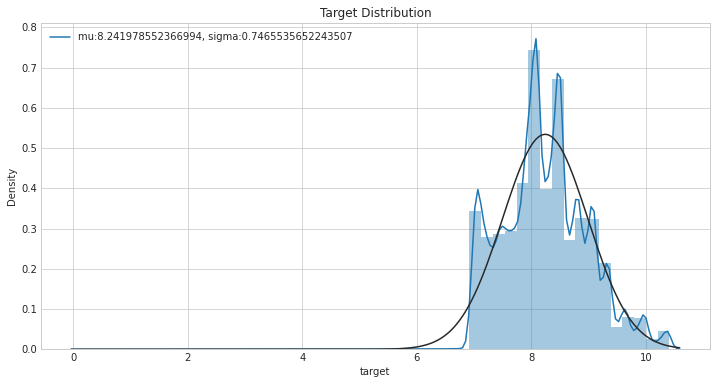

In [3]:
(mu, sigma) = norm.fit(X_full['target'])
plt.figure(figsize = (12,6))
sns.distplot(X_full['target'], kde=True, hist=True, fit=norm)
plt.title('Target Distribution', fontsize=12)
plt.legend([f"mu:{mu}, sigma:{sigma}"],loc="best")
plt.show()

In [4]:
print(f"Skewness: {X_full['target'].skew()}")
print(f"Kurtosis: {X_full['target'].kurt()}")

Skewness: 0.17648662131598555
Kurtosis: 0.7132564609217513


In general skewness should be in range of [-0.5,0.5] and kurtosis in [-2,2].

In [5]:
X_full.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273,8.241979
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950,0.746555
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,0.140329
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669,7.742071
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400,8.191373
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447,8.728634
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.411992


### Feature Visualisation

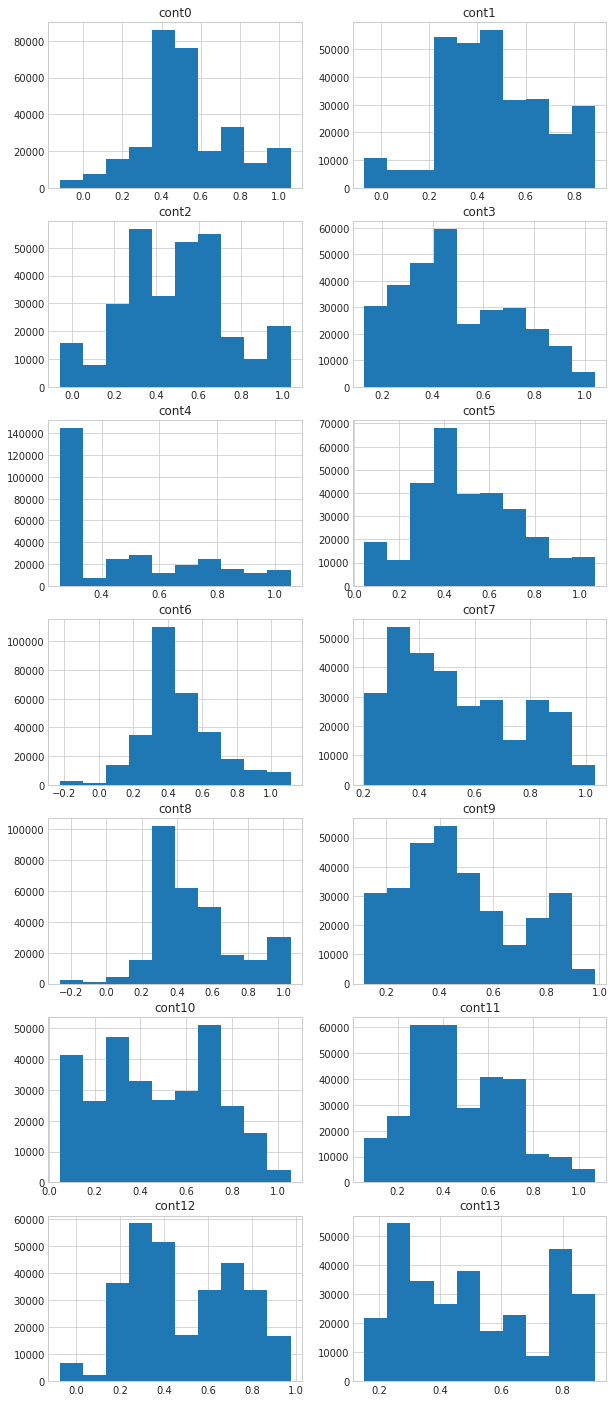

In [6]:
num_types = X_full.select_dtypes(include=['int64', 'float64']).columns[:-1]
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10,25))
for indx,feature in enumerate(num_types):
    row = indx // 2
    col = indx % 2
    X_full[num_types[indx]].hist(ax=axes[row,col]);axes[row,col].set_title(f"{num_types[indx]}")   

### Outlier Detection and Removal 
Though it is recommended to remove outliers for proper model training, there was a dip in performance after removing outliers. This may be because either w/o outliers the model may be overfitting and the outliers are providing a regularization effect in the form of noise or the outliers may be having some important features which may be helping in the final prediction.
In the given cell in order to remove outliers uncomment the single commented line.

In [7]:
mean = X_full['target'].mean()
std = X_full['target'].std()
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off
outliers = X_full[(X_full['target'] < lower) | (X_full['target'] > upper)]
print(f"Orginal Dataset size: {X_full.shape}")
#X_full.drop(outliers.index.to_list(), inplace=True)
print(f"Number of outliers: {len(outliers)}")
print(f"New size: {X_full.shape}")

Orginal Dataset size: (300000, 25)
Number of outliers: 373
New size: (300000, 25)


### Feature Engineering
Feature engineering is one of the most important step for any data science problem.   
It involves transforming the original raw data in a form which helps the model in learning the given function.  
It can include either skipping redundant features or transforming the original feature or adding features.  
To get an idea about the features and its relation to the given target two popular tools used are:
* Correlation
* Mutual Information  

While **correlation** is limited to only linear relationships, **mutual information** can be used for any kind of relationships. *Mutual Information* describes how presence of a given features reduces the uncertainty of the target variable. MI is lower bounded by 0 and there is no upper bound. The variables are independent if MI is 0.

Text(0.5, 1.0, 'Mutual Information')

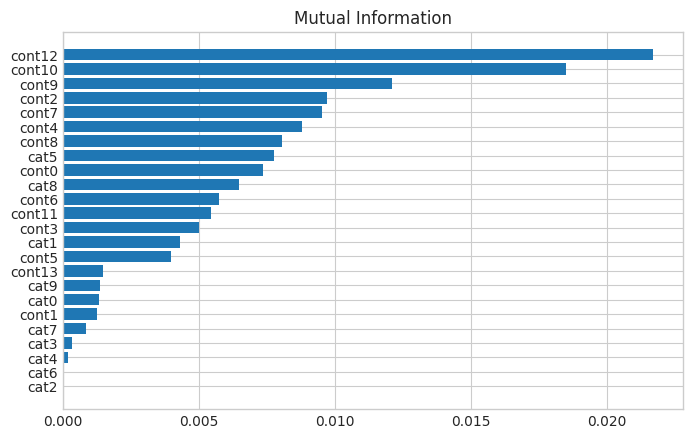

In [8]:
features = X_full.drop(['target'], axis=1, inplace=False)
targets = X_full['target'].copy()

for cols in features.select_dtypes("object"):
    features[cols], _ = features[cols].factorize()
    
discrete_features = features.dtypes == int

mi_value = mutual_info_regression(features, targets, discrete_features=discrete_features)
mi_value = pd.Series(mi_value, name="MI", index=features.columns)
mi_value = mi_value.sort_values(ascending=True)
width = np.arange(len(mi_value))
ticks = list(mi_value.index)

plt.figure(dpi=100, figsize=(8,5))
plt.barh(width, mi_value)
plt.yticks(width, ticks)
plt.title("Mutual Information")

### Extract Features and Target

In [9]:
X_full.columns

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13',
       'target'],
      dtype='object')

In [10]:
X_full.dropna(axis=0, subset=['target'], inplace=True)
y = X_full['target']
X_full.drop(['target'], axis=1, inplace=True)

#### Taking the top N features
Currently all 24 features are being used.

In [11]:
X = X_full[list(mi_value.index)[-24:]]
X_test = X_test_full[list(mi_value.index)[-24:]]

### Analyse the Dataset

In [12]:
print(f"Shape of training data: {X.shape}")
missing_values = X.isnull().sum()
print(missing_values[missing_values > 0])

Shape of training data: (300000, 24)
Series([], dtype: int64)


### Preprocess the Input Data 

In [13]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'bool']).columns

#### Transform the skewed features to normal distribution

In [14]:
skewed_features = X[num_cols].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skewed_features = skewed_features[abs(skewed_features) > 0.75]
print(skewed_features)

for f in skewed_features.index:
    X[f] = np.log1p(X[f])
    X_test[f] = np.log1p(X_test[f])

cont4    0.776594
dtype: float64


In [15]:
print("Number of unique category for each categorical Feature")
for cols in cat_cols:
    print(f"{cols}: {X[cols].nunique()}")

Number of unique category for each categorical Feature
cat2: 2
cat6: 8
cat4: 4
cat3: 4
cat7: 8
cat0: 2
cat9: 15
cat1: 2
cat8: 7
cat5: 4


In [16]:
cat_transformer = OrdinalEncoder()
num_transformer = StandardScaler()
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_cols),
    ('num', num_transformer, num_cols)])

### Training

In [17]:
def train(model):
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)
                     ])

    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    ypred = 0
    total_loss = 0
    for train_indx, test_indx in cv.split(X):
        X_train, X_val = X.iloc[train_indx], X.iloc[test_indx]
        y_train, y_val = y.iloc[train_indx], y.iloc[test_indx]
        clf.fit(X_train, y_train)
        
        yhat = clf.predict(X_val)
        score = mean_squared_error(yhat, y_val, squared=False)
        print(f"Loss:{score}")
        ypred += clf.predict(X_test) / 10
        total_loss += score / 10
        
    print(f"Avg. Loss: {total_loss}")     
    return ypred
    

In [18]:
model = XGBRegressor(n_estimators= 10000, booster='gbtree', tree_method='gpu_hist', 
                    learning_rate= 0.03628302216953097, subsample= 0.7875490025178415, max_depth= 3,
                    colsample_bytree = 0.11807135201147481, reg_alpha = 23.13181079976304, random_state = 1,
                    reg_lambda = 0.0008746338866473539, n_jobs=-1)

final_prediction = train(model)

Loss:0.7168080537029824
Loss:0.716600200186368
Loss:0.7158679982628523
Loss:0.71781701445433
Loss:0.7218302224465655
Loss:0.715120844719446
Loss:0.7179762032711519
Loss:0.7188258848936493
Loss:0.7202779043219029
Loss:0.7132245270316663
Avg. Loss: 0.7174348853290915


### Final Submission

In [19]:
Sample_result['target'] = final_prediction 
Sample_result.to_csv("submission.csv", index=False)